__Dependencies__

In [1]:
import copy  # copy big/deep objects by value
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import os  # OS operations (read/write files/folders)
import warnings  # hide warnings

# process parallelization
from multiprocessing import Lock, Manager, Pool, RawArray, Value, cpu_count

import matplotlib.patches as mpatches  # create custom plot legends
import matplotlib.pyplot as plt  # mother of plots for Python
import matplotlib.ticker as ticker  # matplotlib ticker utils
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import display  # print nicely
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

__Options and constants__

In [2]:
warnings.filterwarnings("ignore")
# set default float display format to 2 decimals
pd.options.display.float_format = "{:.3f}".format

STYLE = "whitegrid"
sns.set(rc={"figure.figsize": (20, 8)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

PATH_PROC = "./data/processed"

# hit groups to skip
EXCEPT_GROUPS = ["End", "Events", "Start"]

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""

CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")

Total CPU threads: 4


__Helper functions__

In [3]:
def pbar_fork_hack(l=None):
    """
    Hack to enforce progress bars to be displayed by fork processes on
    IPython Apps like Jupyter Notebooks.

    Avoids [IPKernelApp] WARNING | WARNING: attempted to send message from fork

    Important: pass this function as argument for the initializer parameter
    while initializing a multiprocessing pool to make it work. E.g.:

    pool = Pool(processes=N_CORES, initializer=pbar_fork_hack)

    Source:
     - https://github.com/ipython/ipython/issues/11049#issue-306086846
     - https://github.com/tqdm/tqdm/issues/485#issuecomment-473338308
    """
    if l:
        global lock
        lock = l
    print(" ", end="", flush=True)


def angle(a, b):
    """
    Angle (in degrees) between two vectors.

    Given two 3D vectors (a and b):
    a = [xa, ya, za] , b = [xb, yb, zb]

    And the basic geometric formula for the dot product:
    a · b = |a| * |b| * cos(α) => α = arccos[(a · b) / (|a| * |b|)]

    In other words:
    angle = arccos[(xa * xb + ya * yb + za * zb) / (√(xa2 + ya2 + za2) * √(xb2 + yb2 + zb2))]

    Source: https://www.omnicalculator.com/math/angle-between-two-vectors

    Parameters:
        a (numpy.array): First vector
        b (numpy.array): Second vector
    Returns:
        float: Angle between vectors a and b in degrees.
    """
    # a · b
    dotp = np.dot(a, b)

    # magnitude vectors |a| and |b|
    m_a = np.linalg.norm(a)
    m_b = np.linalg.norm(b)

    # |a| * |b|
    m_prod = m_a * m_b

    # (a * b) / (|a| * |b|)
    res = dotp / m_prod

    # α = arccos[(a · b) / (|a| * |b|)]
    an = np.arccos(res)

    # calculated angle from radians to degrees
    return np.degrees(an)

__Read participants cleaned data__

In [4]:
parts = pd.read_csv("./participants_clean.csv")
parts = parts.set_index("id")  # set uid column as index (remove default)
parts

,date,expo,side,condition,questionnaire,nulls_%
id,,,,,,
4f583872ffed48249874b00f3d389cfc,2019-05-14 13:21:00,MSW,right,TaxiDriver,No,1.610
33d68ad55ef544fab9fd08108e3913ca,2019-05-14 16:44:00,MSW,right,AVAS,No,0.037
8598a83e2af441b8bcd0ae5d84beb875,2019-05-14 16:51:00,MSW,right,RadioTalk,No,0.037
37d7e67934974217830bb429bba7fd76,2019-05-14 16:54:00,MSW,left,AVAS,No,0.936
42bac596059749b5b8e8e83ae61de9b4,2019-05-14 16:56:00,MSW,right,TaxiDriver,No,0.225
...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,2019-12-30 15:29:00,BMBF,right,AVAS,No,0.300
611d35a7c3e940cc82495e53c2a8532d,2020-01-03 16:12:00,BMBF,right,TaxiDriver,No,0.674
3b6fda285d9e412eb081986b2f22a2e3,2020-01-03 16:13:00,BMBF,left,AVAS,No,1.984


In [5]:
COL = "nulls_%"
parts[parts[COL] > 5].sort_values(by=[COL]).index.size

48

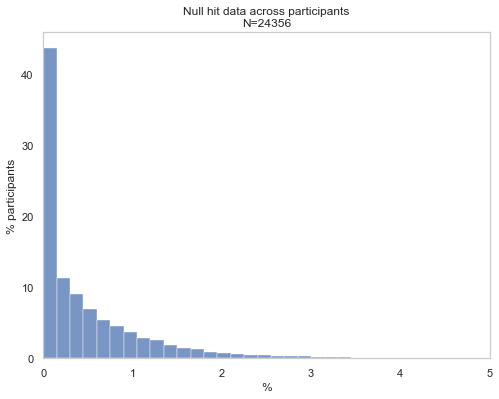

In [6]:
sns.set(rc={"figure.figsize": (8, 6)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

ax = sns.histplot(data=parts["nulls_%"], stat="percent", bins=100)

ax.set_xlim(0, 5)
ax.grid(False)
ax.set_xlabel("%")
ax.set_ylabel("% participants")

plt.title(f"Null hit data across participants\nN={parts.index.size}")
plt.show()

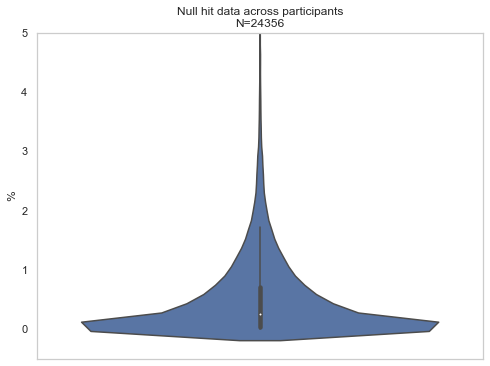

In [7]:
sns.set(rc={"figure.figsize": (8, 6)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

ax = sns.violinplot(data=parts["nulls_%"], stat="percent")

ax.set_ylim(-0.5, 5)
ax.grid(False)
ax.set_xticklabels([])
ax.set_ylabel("%")

plt.title(f"Null hit data across participants\nN={parts.index.size}")
plt.show()

In [8]:
def correct_event_objects(uid):
    """
    Correct critical events (jogging, fast car, walking) object groups of a
    participant given its UID.

    Parameters:
        uid (str): Participant unique identifier.
    """
    # read participant hit data
    p = pd.read_csv(f"{PATH_PROC}/hits/{uid}.csv")

    # indices from critical event object names (if any)
    jogging = p["name"].str.contains(EV_0, regex=False, na=False)
    car_con = p["name"].str.contains(EV_1, regex=False, na=False)
    walking = p["name"].str.contains(EV_2, regex=False, na=False)
    ped_con = jogging | walking  # unify indices (pedestrian events)

    # select rows from whole hit data
    dudes = p[ped_con]
    car = p[car_con]
    changed = False  # to control if changes applied

    # if any row found for the events, apply changes
    if dudes.index.size > 0:
        dudes.group = "Dynamic Pedestrians"
        p[ped_con] = dudes
        changed = True
    if car.index.size > 0:
        car.group = "Dynamic Cars"
        p[car_con] = car
        changed = True

    # store into CSV only if changes were made
    if changed:
        p.to_csv(f"{PATH_PROC}/hits/{uid}.csv", index=False)


EV_0 = "Event 2.1 (2) Running"
EV_1 = "S_SUV03"
EV_2 = "event 2.2 walking"

# participants ids
uids = parts.index.tolist()

# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack)

# participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap_unordered(func=correct_event_objects, iterable=uids),
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

📄 0 of 24356 📂 participants processed:                                                                        …

__Collect and display all object groups across all participants__

In [10]:
def collect_groups(uid):
    """
    Collect all unique object groups given a participant UID.
    Parameters:
        uid (str): Participant UID to process.
    """
    cur = pd.read_csv(f"{PATH_PROC}/hits/{uid}.csv")

    gs = cur.group.unique()
    for g in gs:
        if not pd.isnull(g):
            lock.acquire()
            if g not in groups:
                groups.append(g)
            lock.release()


manager = Manager()  # manage shared memory types

# convert into memory-shared dict of lists for multiprocessing
groups = manager.list()

# multiprocessing lock to avoid raicing conditions
l = Lock()

# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack, initargs=(l,))

# participants uids to process
uids = parts.index.tolist()

# participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap(func=collect_groups, iterable=uids),
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

# cast proxy object to list (otherwise they can't be accessed)
groups = list(groups)
# sort list alphabetically
groups.sort()
display(groups)

📄 0 of 24356 📂 participants processed:                                                                        …

['Buildings',
 'Crosswalks',
 'Dynamic Cars',
 'Dynamic Pedestrians',
 'End',
 'Events',
 'Inside Car',
 'Nature',
 'Roads',
 'Sky',
 'Start',
 'Static Cars',
 'Static Pedestrians',
 'Street Objects',
 'Traffic Lights',
 'Traffic Signs']

__Collect and store all object unique groups and names across all participants__

In [11]:
def collect_names(uid):
    """
    Collect all unique object names given a participant UID.
    Parameters:
        uid (str): Participant UID to process.
    """
    cur = pd.read_csv(f"{PATH_PROC}/hits/{uid}.csv")
    for grp in groups:
        names[uid][grp] = cur[cur.group == grp].name.unique()


def unique_names(grp):
    """
    Check all participants and get all unique object names given a group.
    Parameters:
        grp (str): Object group name.
    """
    for uid in uids:
        cum = list(unique[grp])
        cur = list(names[uid][grp])
        unique[grp] = list(set(cum + cur))


groups = [
    "Buildings",
    "Crosswalks",
    "Dynamic Cars",
    "Dynamic Pedestrians",
    "End",
    "Events",
    "Inside Car",
    "Nature",
    "Roads",
    "Sky",
    "Start",
    "Static Cars",
    "Static Pedestrians",
    "Street Objects",
    "Traffic Lights",
    "Traffic Signs",
]

manager = Manager()  # manage shared memory types

# participants uids to process
uids = parts.index.tolist()

# uids progress bar
uids_pbar = tqdm(
    iterable=uids,
    total=len(uids),
    desc="📂 uids",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

gs = {grp: manager.list() for grp in groups}

# create memory-shared dict of lists for multiprocessing
names = manager.dict({uid: manager.dict(gs) for uid in uids_pbar})
unique = manager.dict({grp: manager.list() for grp in groups})

# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack, initargs=(l,))

# participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap(func=collect_names, iterable=uids),
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

# After collecting them, get all unique names per group across participants
# TODO:
# - Find a way to see the progress while unifying the groups across parts

# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack, initargs=(l,))

# groups progress bar
groups_pbar = tqdm(
    iterable=pool.imap(func=unique_names, iterable=groups),
    total=len(groups),
    desc="📂 groups",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in groups_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

📄 0 of 24356 📂 uids processed:                                                                                …

📄 0 of 24356 📂 participants processed:                                                                        …

📄 0 of 16 📂 groups processed:                                                                                 …

Store them

In [12]:
# cast proxy object/s (otherwise they can't be accessed)
names = dict(unique)

with open(f"./groups_and_names.json", "w") as f:
    json.dump(names, f, indent=4)

Process all participants counting and groupping consecutive hitpoints

In [ ]:
EXCEPT_GROUPS = ["End", "Events", "Sky", "Start"]


def nearest_hit(df):
    """
    Add description.

    Parameters:
        df (pd.DataFrame): Add desc.
    Returns:
        found (bool): Add desc.
        row (pd.Series): Add desc.
    """
    idxs = df.index.tolist()
    found = False
    for idx in idxs:
        c = df.loc[idx]
        row = c if c.group not in EXCEPT_GROUPS and c.group != "" else None
        found = not isinstance(row, type(None))
        if found:
            break
    return found, row


def collect_hit_events(uid):
    """
    Collect hit (saccade/gaze) events and related info of a participant given
    its UID.

    Parameters:
        uid (str): Participant unique identifier.
    """
    # read current participant origins and hits datasets
    orgs = pd.read_csv(f"{PATH_PROC}/origins/{uid}.csv")
    orgs = orgs.set_index("frame")  # set frame column as index
    hits = pd.read_csv(f"{PATH_PROC}/hits/{uid}.csv")

    frames = orgs.index.tolist()  # all frames (0-2670)

    # dict to collect gaze events info
    h_events = {
        "name": [],
        "group": [],
        "start": [],
        "end": [],
        "nHits": [],
        "distance": [],
        "length": [],
        "type": [],
    }

    # dict to check consecutives
    check = {"p": None, "start": None, "cnt": 0}
    dist = []
    for f in frames:  # for each frame
        cur = hits[hits.frame == f]
        # closest object hit if not in exceptions nor null, otherwise next
        found, cur = nearest_hit(cur)
        if found:
            d = float(cur.distance)
            name = cur["name"]  # .name calls .Name of the series!!
            group = cur.group
            if f < len(frames) - 1:
                fou, nex = nearest_hit(hits[hits.frame == f + 1])
                nex_name = nex["name"] if fou else None
                nex_grp = nex.group if fou else None
            else:
                nex_name = None
            if not check["p"]:  # not previous yet or ATM
                dist = []
                dist.append(d)
                check["p"] = name
                check["start"] = f
                check["cnt"] += 1
            else:
                dist.append(d)
                check["p"] = name
                check["cnt"] += 1
            if name != nex_name:
                d = sum(dist) / len(dist)
                d = round(d, 3)
                n_hits = check["cnt"]
                e_type = "gaze" if n_hits > 7 else "rest"
                h_events["name"].append(name)
                h_events["group"].append(group)
                h_events["start"].append(check["start"])
                h_events["end"].append(f)
                h_events["nHits"].append(n_hits)
                h_events["distance"].append(d)
                h_events["length"].append(n_hits * 0.033)
                h_events["type"].append(e_type)
                # reset
                check = {"p": None, "start": None, "cnt": 0}
                store = False

    h_events = pd.DataFrame(h_events)
    h_events.to_csv(f"{PATH_PROC}/gazes/{uid}.csv", index=False)


# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack)

# participants ids
uids = parts.index.tolist()

# participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap_unordered(func=collect_hit_events, iterable=uids),
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

📄 0 of 24356 📂 participants processed:                                                                        …

Find event frames

In [63]:
def event_frames(uid):
    """
    Collect event frames and object names of a participant given
    its UID.

    Parameters:
        uid (str): Participant unique identifier.
    """
    h_events = pd.read_csv(f"{PATH_PROC}/gazes/{uid}.csv")
    h_events = h_events[h_events.group == "Events"]
    hev_frames[uid] = h_events.start.tolist()


# participants ids
uids = parts.index.tolist()

manager = Manager()  # manage shared memory types

# convert into memory-shared dict of dicts for multiprocessing
hev_frames = manager.dict({uid: manager.list() for uid in uids})

# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack)

# participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap_unordered(func=event_frames, iterable=uids),
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

📄 0 of 24356 📂 participants processed:                                                                        …

In [64]:
test = dict(hev_frames)
test = {k: list(v) for k, v in test.items()}

In [80]:
with open("frames_events.json", "w") as outfile:
    json.dump(test, outfile)

In [5]:
with open("frames_events.json") as f:
    test = json.load(f)

In [17]:
for k in list(test.keys())[:1]:
    print(type(test[k]))

<class 'list'>


In [ ]:
"""
Event1: 1162-1400
Event2: 1958-2080
Event3: 2596-2890
"""

📄 0 of 24356 📂 participants processed:                                                                        …

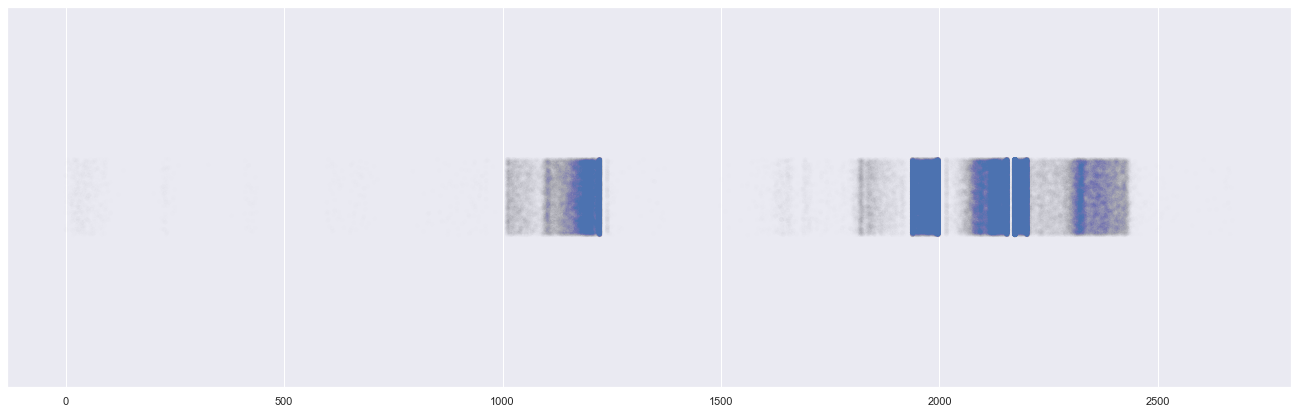

In [19]:
sns.set(rc={"figure.figsize": (23, 7)})

keys = list(test.keys())
# participants progress bar
keys_pbar = tqdm(
    iterable=keys,
    total=len(keys),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for k in keys_pbar:
    sns.stripplot(x=test[k], alpha=0.005)
plt.show()

In [9]:
def gazes_vs_saccades(uid):
    """
    Collect hit (saccade/gaze) events and related info of a participant given
    its UID.

    Parameters:
        uid (str): Participant unique identifier.
    """
    h_events = pd.read_csv(f"{PATH_PROC}/gazes/{uid}.csv")
    h_events = h_events[h_events.group != "Sky"]
    total = h_events.index.size

    rest = h_events[h_events["type"] == "rest"]
    gazes = h_events[h_events["type"] == "gaze"]

    total_r = rest.index.size
    total_g = gazes.index.size
    rest_len = rest["length"].sum()
    gaze_len = gazes["length"].sum()
    total_len = rest_len + gaze_len

    hev_cnts[uid]["rest_cnt"] = total_r
    hev_cnts[uid]["gaze_cnt"] = total_g
    hev_cnts[uid]["rest_avg"] = rest["length"].mean()
    hev_cnts[uid]["gaze_avg"] = gazes["length"].mean()
    hev_cnts[uid]["rest_len"] = rest_len
    hev_cnts[uid]["gaze_len"] = gaze_len
    hev_cnts[uid]["rest_l_%"] = rest_len * 100 / total_len
    hev_cnts[uid]["gaze_l_%"] = gaze_len * 100 / total_len
    hev_cnts[uid]["rest_c_%"] = total_r * 100 / total
    hev_cnts[uid]["gaze_c_%"] = total_g * 100 / total

    grps = gazes.group.unique()
    for grp in grps:
        sel = gazes[gazes.group == grp]
        g_len = sel["length"].sum()
        g_cnt = sel.index.size
        grp_lpercs[uid][grp] = g_len * 100 / gaze_len
        grp_cpercs[uid][grp] = g_cnt * 100 / total_g
    for grp in grp_cats:
        if not grp_lpercs[uid][grp]:
            grp_lpercs[uid][grp] = 0
        if not grp_cpercs[uid][grp]:
            grp_cpercs[uid][grp] = 0


# participants ids
uids = parts.index.tolist()

cats = [
    "rest_cnt",
    "gaze_cnt",
    "rest_avg",
    "gaze_avg",
    "rest_len",
    "gaze_len",
    "rest_l_%",
    "gaze_l_%",
    "rest_c_%",
    "gaze_c_%",
]
stats = {cat: None for cat in cats}

grp_cats = [
    "Buildings",
    "Crosswalks",
    "Dynamic Cars",
    "Dynamic Pedestrians",
    # "End",
    # "Events",
    "Inside Car",
    "Nature",
    "Roads",
    "Sky",
    # "Start",
    "Static Cars",
    "Static Pedestrians",
    "Street Objects",
    "Traffic Lights",
    "Traffic Signs",
]
grp_lstats = {cat: None for cat in grp_cats}
grp_cstats = grp_lstats

manager = Manager()  # manage shared memory types

# convert into memory-shared dict of dicts for multiprocessing
hev_cnts = manager.dict({uid: manager.dict(stats) for uid in uids})
grp_lpercs = manager.dict({uid: manager.dict(grp_lstats) for uid in uids})
grp_cpercs = manager.dict({uid: manager.dict(grp_cstats) for uid in uids})

# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack)

# participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap_unordered(func=gazes_vs_saccades, iterable=uids),
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

# parse and store collected data
hev_cnts = dict(hev_cnts)
hev_cnts = {k: dict(v) for k, v in hev_cnts.items()}
hev_cnts = pd.DataFrame(hev_cnts).transpose()
hev_cnts.to_csv("./hit_events_counters.csv")
display(hev_cnts)

grp_lpercs = dict(grp_lpercs)
grp_cpercs = dict(grp_cpercs)
grp_lpercs = {k: dict(v) for k, v in grp_lpercs.items()}
grp_cpercs = {k: dict(v) for k, v in grp_cpercs.items()}
grp_lpercs = pd.DataFrame(grp_lpercs).transpose()
grp_cpercs = pd.DataFrame(grp_cpercs).transpose()
grp_lpercs.to_csv("./group_length_percentages.csv")
grp_cpercs.to_csv("./group_counts_percentages.csv")
display(grp_lpercs)
display(grp_cpercs)

📄 0 of 24356 📂 participants processed:                                                                        …

,rest_cnt,gaze_cnt,rest_avg,gaze_avg,rest_len,gaze_len,rest_l_%,gaze_l_%,rest_c_%,gaze_c_%
4f583872ffed48249874b00f3d389cfc,372.000,70.000,0.065,0.907,24.255,63.492,27.642,72.358,84.163,15.837
33d68ad55ef544fab9fd08108e3913ca,282.000,81.000,0.085,0.793,23.925,64.218,27.143,72.857,77.686,22.314
8598a83e2af441b8bcd0ae5d84beb875,108.000,59.000,0.092,1.326,9.900,78.243,11.232,88.768,64.671,35.329
37d7e67934974217830bb429bba7fd76,487.000,75.000,0.061,0.777,29.766,58.311,33.795,66.205,86.655,13.345
42bac596059749b5b8e8e83ae61de9b4,343.000,78.000,0.075,0.802,25.608,62.535,29.053,70.947,81.473,18.527
...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,227.000,90.000,0.082,0.772,18.645,69.498,21.153,78.847,71.609,28.391
611d35a7c3e940cc82495e53c2a8532d,348.000,64.000,0.068,1.005,23.760,64.317,26.976,73.024,84.466,15.534
3b6fda285d9e412eb081986b2f22a2e3,444.000,90.000,0.067,0.647,29.865,58.212,33.908,66.092,83.146,16.854
18ffb0abdc8642098c479380bfa533d1,478.000,85.000,0.071,0.635,34.089,53.955,38.718,61.282,84.902,15.098


,Buildings,Crosswalks,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Sky,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
4f583872ffed48249874b00f3d389cfc,28.378,15.073,0.728,1.767,2.963,4.834,23.909,0.000,0.000,0.000,1.351,20.998,0.000
33d68ad55ef544fab9fd08108e3913ca,0.000,1.387,0.925,0.000,43.525,0.462,45.940,0.000,0.000,0.000,0.565,7.194,0.000
8598a83e2af441b8bcd0ae5d84beb875,46.689,5.356,0.000,0.000,0.801,1.181,0.000,33.741,0.000,0.000,0.464,11.767,0.000
37d7e67934974217830bb429bba7fd76,29.881,12.224,3.735,1.188,8.093,7.357,2.264,0.000,0.566,0.000,2.490,32.201,0.000
42bac596059749b5b8e8e83ae61de9b4,52.507,9.551,0.000,0.000,0.844,6.860,0.000,10.765,0.000,0.000,2.902,16.570,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,46.534,5.888,0.000,0.000,9.259,3.941,0.000,20.513,0.000,0.000,1.472,12.393,0.000
611d35a7c3e940cc82495e53c2a8532d,29.451,3.746,0.410,0.410,37.506,7.594,4.413,0.000,0.000,0.000,1.642,14.264,0.564
3b6fda285d9e412eb081986b2f22a2e3,11.565,6.463,0.000,1.247,31.406,1.134,26.757,0.567,0.000,1.927,9.127,9.807,0.000
18ffb0abdc8642098c479380bfa533d1,26.911,9.786,0.000,0.000,9.541,8.318,12.294,7.584,0.000,0.000,3.242,21.162,1.162


,Buildings,Crosswalks,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Sky,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
4f583872ffed48249874b00f3d389cfc,31.429,12.857,1.429,1.429,4.286,8.571,25.714,0.000,0.000,0.000,4.286,10.000,0.000
33d68ad55ef544fab9fd08108e3913ca,0.000,1.235,2.469,0.000,50.617,1.235,40.741,0.000,0.000,0.000,1.235,2.469,0.000
8598a83e2af441b8bcd0ae5d84beb875,38.983,10.169,0.000,0.000,3.390,5.085,0.000,28.814,0.000,0.000,1.695,11.864,0.000
37d7e67934974217830bb429bba7fd76,37.333,9.333,2.667,2.667,13.333,12.000,5.333,0.000,1.333,0.000,6.667,9.333,0.000
42bac596059749b5b8e8e83ae61de9b4,48.718,8.974,0.000,0.000,2.564,11.538,0.000,10.256,0.000,0.000,6.410,11.538,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,45.556,5.556,0.000,0.000,10.000,6.667,0.000,21.111,0.000,0.000,2.222,8.889,0.000
611d35a7c3e940cc82495e53c2a8532d,31.250,6.250,1.562,1.562,29.688,12.500,6.250,0.000,0.000,0.000,4.688,4.688,1.562
3b6fda285d9e412eb081986b2f22a2e3,10.000,5.556,0.000,2.222,30.000,2.222,28.889,1.111,0.000,2.222,11.111,6.667,0.000
18ffb0abdc8642098c479380bfa533d1,29.412,4.706,0.000,0.000,14.118,12.941,12.941,4.706,0.000,0.000,5.882,12.941,2.353


In [10]:
display(hev_cnts.describe())

,rest_cnt,gaze_cnt,rest_avg,gaze_avg,rest_len,gaze_len,rest_l_%,gaze_l_%,rest_c_%,gaze_c_%
count,24356.000,24356.000,24355.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000
mean,343.961,71.816,0.074,0.951,24.834,63.240,28.199,71.801,80.380,19.620
std,146.227,12.613,0.008,0.796,9.292,9.313,10.556,10.556,7.475,7.475
min,0.000,1.000,0.033,0.458,0.000,27.654,0.000,31.398,0.000,5.847
25%,238.000,65.000,0.069,0.717,18.249,56.694,20.704,64.395,77.179,14.484
50%,341.000,73.000,0.073,0.838,25.047,63.030,28.427,71.573,82.035,17.965
75%,444.000,80.000,0.079,1.028,31.350,69.861,35.605,79.296,85.516,22.821
max,950.000,108.000,0.132,88.143,60.423,88.143,68.602,100.000,94.153,100.000


In [20]:
hit_levs = pd.read_csv(f"./group_length_percentages.csv", index_col=0)
hit_levs

,Buildings,Crosswalks,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Sky,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
4f583872ffed48249874b00f3d389cfc,28.378,15.073,0.728,1.767,2.963,4.834,23.909,0.000,0.000,0.000,1.351,20.998,0.000
33d68ad55ef544fab9fd08108e3913ca,0.000,1.387,0.925,0.000,43.525,0.462,45.940,0.000,0.000,0.000,0.565,7.194,0.000
8598a83e2af441b8bcd0ae5d84beb875,46.689,5.356,0.000,0.000,0.801,1.181,0.000,33.741,0.000,0.000,0.464,11.767,0.000
37d7e67934974217830bb429bba7fd76,29.881,12.224,3.735,1.188,8.093,7.357,2.264,0.000,0.566,0.000,2.490,32.201,0.000
42bac596059749b5b8e8e83ae61de9b4,52.507,9.551,0.000,0.000,0.844,6.860,0.000,10.765,0.000,0.000,2.902,16.570,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,46.534,5.888,0.000,0.000,9.259,3.941,0.000,20.513,0.000,0.000,1.472,12.393,0.000
611d35a7c3e940cc82495e53c2a8532d,29.451,3.746,0.410,0.410,37.506,7.594,4.413,0.000,0.000,0.000,1.642,14.264,0.564
3b6fda285d9e412eb081986b2f22a2e3,11.565,6.463,0.000,1.247,31.406,1.134,26.757,0.567,0.000,1.927,9.127,9.807,0.000
18ffb0abdc8642098c479380bfa533d1,26.911,9.786,0.000,0.000,9.541,8.318,12.294,7.584,0.000,0.000,3.242,21.162,1.162


In [21]:
hit_cevs = pd.read_csv(f"./group_counts_percentages.csv", index_col=0)
hit_cevs

,Buildings,Crosswalks,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Sky,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
4f583872ffed48249874b00f3d389cfc,31.429,12.857,1.429,1.429,4.286,8.571,25.714,0.000,0.000,0.000,4.286,10.000,0.000
33d68ad55ef544fab9fd08108e3913ca,0.000,1.235,2.469,0.000,50.617,1.235,40.741,0.000,0.000,0.000,1.235,2.469,0.000
8598a83e2af441b8bcd0ae5d84beb875,38.983,10.169,0.000,0.000,3.390,5.085,0.000,28.814,0.000,0.000,1.695,11.864,0.000
37d7e67934974217830bb429bba7fd76,37.333,9.333,2.667,2.667,13.333,12.000,5.333,0.000,1.333,0.000,6.667,9.333,0.000
42bac596059749b5b8e8e83ae61de9b4,48.718,8.974,0.000,0.000,2.564,11.538,0.000,10.256,0.000,0.000,6.410,11.538,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,45.556,5.556,0.000,0.000,10.000,6.667,0.000,21.111,0.000,0.000,2.222,8.889,0.000
611d35a7c3e940cc82495e53c2a8532d,31.250,6.250,1.562,1.562,29.688,12.500,6.250,0.000,0.000,0.000,4.688,4.688,1.562
3b6fda285d9e412eb081986b2f22a2e3,10.000,5.556,0.000,2.222,30.000,2.222,28.889,1.111,0.000,2.222,11.111,6.667,0.000
18ffb0abdc8642098c479380bfa533d1,29.412,4.706,0.000,0.000,14.118,12.941,12.941,4.706,0.000,0.000,5.882,12.941,2.353


In [22]:
hit_levs = hit_levs.join(
    parts[["expo", "side", "condition", "questionnaire"]], how="outer"
)
hit_levs

,Buildings,Crosswalks,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Sky,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs,expo,side,condition,questionnaire
4f583872ffed48249874b00f3d389cfc,28.378,15.073,0.728,1.767,2.963,4.834,23.909,0.000,0.000,0.000,1.351,20.998,0.000,MSW,right,TaxiDriver,No
33d68ad55ef544fab9fd08108e3913ca,0.000,1.387,0.925,0.000,43.525,0.462,45.940,0.000,0.000,0.000,0.565,7.194,0.000,MSW,right,AVAS,No
8598a83e2af441b8bcd0ae5d84beb875,46.689,5.356,0.000,0.000,0.801,1.181,0.000,33.741,0.000,0.000,0.464,11.767,0.000,MSW,right,RadioTalk,No
37d7e67934974217830bb429bba7fd76,29.881,12.224,3.735,1.188,8.093,7.357,2.264,0.000,0.566,0.000,2.490,32.201,0.000,MSW,left,AVAS,No
42bac596059749b5b8e8e83ae61de9b4,52.507,9.551,0.000,0.000,0.844,6.860,0.000,10.765,0.000,0.000,2.902,16.570,0.000,MSW,right,TaxiDriver,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,46.534,5.888,0.000,0.000,9.259,3.941,0.000,20.513,0.000,0.000,1.472,12.393,0.000,BMBF,right,AVAS,No
611d35a7c3e940cc82495e53c2a8532d,29.451,3.746,0.410,0.410,37.506,7.594,4.413,0.000,0.000,0.000,1.642,14.264,0.564,BMBF,right,TaxiDriver,No
3b6fda285d9e412eb081986b2f22a2e3,11.565,6.463,0.000,1.247,31.406,1.134,26.757,0.567,0.000,1.927,9.127,9.807,0.000,BMBF,left,AVAS,No
18ffb0abdc8642098c479380bfa533d1,26.911,9.786,0.000,0.000,9.541,8.318,12.294,7.584,0.000,0.000,3.242,21.162,1.162,BMBF,left,RadioTalk,Yes


In [23]:
hit_cevs = hit_cevs.join(
    parts[["expo", "side", "condition", "questionnaire"]], how="outer"
)
hit_cevs

,Buildings,Crosswalks,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Sky,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs,expo,side,condition,questionnaire
4f583872ffed48249874b00f3d389cfc,31.429,12.857,1.429,1.429,4.286,8.571,25.714,0.000,0.000,0.000,4.286,10.000,0.000,MSW,right,TaxiDriver,No
33d68ad55ef544fab9fd08108e3913ca,0.000,1.235,2.469,0.000,50.617,1.235,40.741,0.000,0.000,0.000,1.235,2.469,0.000,MSW,right,AVAS,No
8598a83e2af441b8bcd0ae5d84beb875,38.983,10.169,0.000,0.000,3.390,5.085,0.000,28.814,0.000,0.000,1.695,11.864,0.000,MSW,right,RadioTalk,No
37d7e67934974217830bb429bba7fd76,37.333,9.333,2.667,2.667,13.333,12.000,5.333,0.000,1.333,0.000,6.667,9.333,0.000,MSW,left,AVAS,No
42bac596059749b5b8e8e83ae61de9b4,48.718,8.974,0.000,0.000,2.564,11.538,0.000,10.256,0.000,0.000,6.410,11.538,0.000,MSW,right,TaxiDriver,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,45.556,5.556,0.000,0.000,10.000,6.667,0.000,21.111,0.000,0.000,2.222,8.889,0.000,BMBF,right,AVAS,No
611d35a7c3e940cc82495e53c2a8532d,31.250,6.250,1.562,1.562,29.688,12.500,6.250,0.000,0.000,0.000,4.688,4.688,1.562,BMBF,right,TaxiDriver,No
3b6fda285d9e412eb081986b2f22a2e3,10.000,5.556,0.000,2.222,30.000,2.222,28.889,1.111,0.000,2.222,11.111,6.667,0.000,BMBF,left,AVAS,No
18ffb0abdc8642098c479380bfa533d1,29.412,4.706,0.000,0.000,14.118,12.941,12.941,4.706,0.000,0.000,5.882,12.941,2.353,BMBF,left,RadioTalk,Yes


In [24]:
display(hit_levs.describe())
display(hit_cevs.describe())

,Buildings,Crosswalks,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Sky,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
count,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000
mean,22.703,7.017,0.638,0.212,31.920,3.517,16.303,4.263,0.047,0.032,1.511,11.576,0.261
std,18.353,5.507,1.213,0.677,26.066,3.646,17.318,8.228,0.239,0.226,1.812,5.679,0.844
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.221,2.431,0.000,0.000,9.016,0.492,2.671,0.000,0.000,0.000,0.000,6.948,0.000
50%,21.248,6.036,0.000,0.000,24.849,2.509,10.943,0.473,0.000,0.000,0.938,10.863,0.000
75%,38.749,10.645,0.796,0.000,52.559,5.485,24.199,4.388,0.000,0.000,2.270,15.199,0.000
max,72.321,29.241,12.033,15.648,100.000,30.166,100.000,69.310,5.570,7.831,21.726,36.114,11.768


,Buildings,Crosswalks,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Sky,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
count,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000
mean,23.101,5.886,0.901,0.394,32.732,5.845,16.244,4.594,0.088,0.051,2.816,6.851,0.497
std,17.039,3.578,1.479,1.097,23.383,5.349,14.673,8.019,0.399,0.288,3.132,3.742,1.485
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,6.579,2.941,0.000,0.000,12.658,1.282,3.797,0.000,0.000,0.000,0.000,3.846,0.000
50%,22.727,5.882,0.000,0.000,28.125,4.839,13.105,1.205,0.000,0.000,1.887,6.593,0.000
75%,37.662,8.333,1.389,0.000,51.852,9.231,25.287,5.556,0.000,0.000,4.211,9.375,0.000
max,67.647,20.690,12.963,17.949,100.000,34.118,100.000,59.677,7.463,4.478,30.488,24.138,18.966


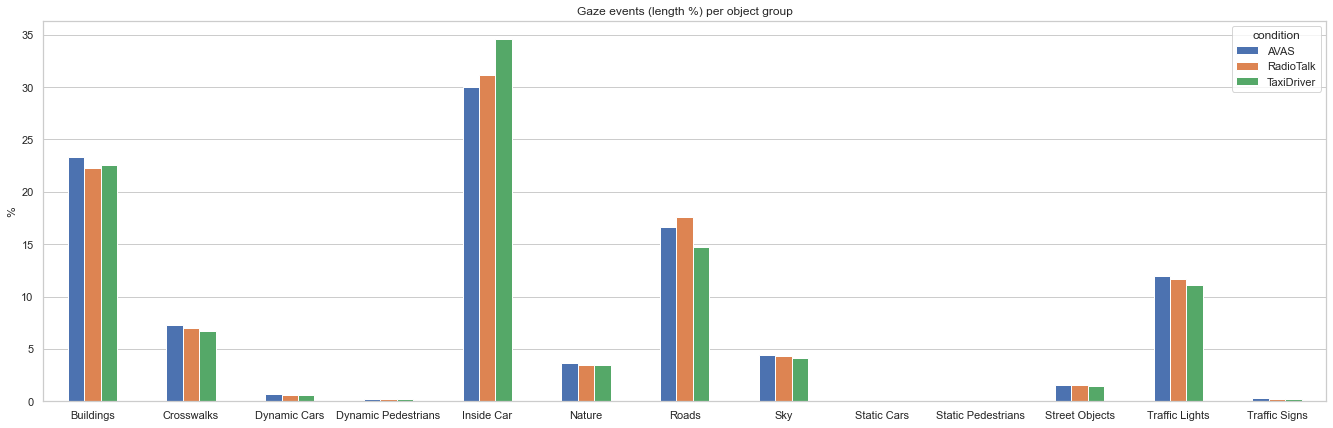

In [35]:
sns.set(rc={"figure.figsize": (23, 7)})
sns.set_style(STYLE)  # set seaborn plotting style

ax = hit_levs.groupby(["condition"]).mean().transpose().plot.bar(rot=0)

ax.set_ylabel("%")
ax.xaxis.grid(False)

plt.title("Gaze events (length %) per object group")

plt.show()

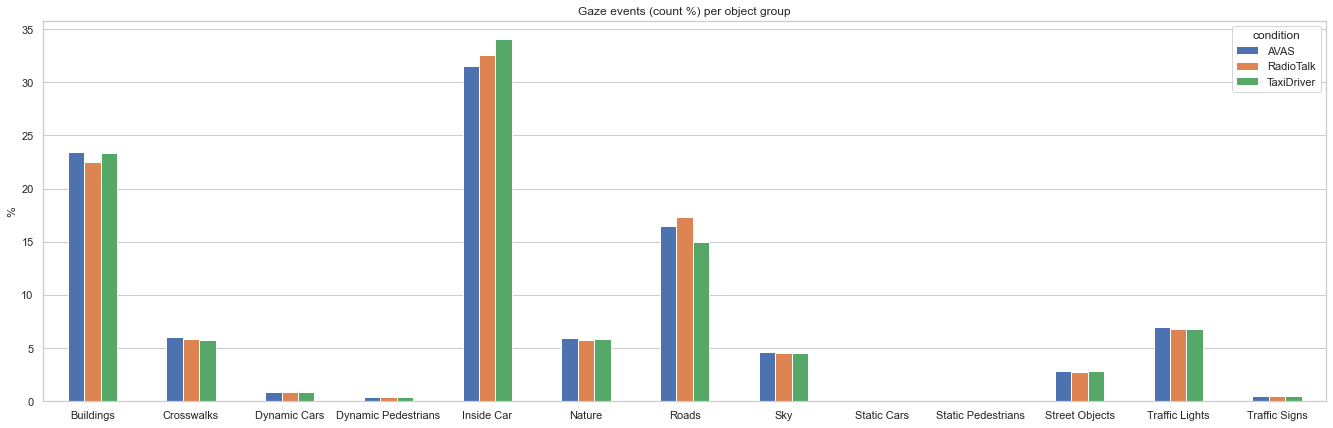

In [39]:
sns.set(rc={"figure.figsize": (23, 7)})
sns.set_style(STYLE)  # set seaborn plotting style

ax = hit_cevs.groupby(["condition"]).mean().transpose().plot.bar(rot=0)

ax.set_ylabel("%")
ax.xaxis.grid(False)

plt.title("Gaze events (count %) per object group")

plt.show()

In [28]:
grp_cats = [
    "Buildings",
    "Crosswalks",
    "Dynamic Cars",
    "Dynamic Pedestrians",
    # "End",
    # "Events",
    "Inside Car",
    "Nature",
    "Roads",
    # "Sky",
    # "Start",
    "Static Cars",
    "Static Pedestrians",
    "Street Objects",
    "Traffic Lights",
    "Traffic Signs",
]

palette = itertools.cycle(sns.color_palette(palette="deep"))  # color palette

colors = [next(palette) for i in range(3)]

sns.set_style(STYLE)  # set seaborn plotting style


def normalize_from_condition(s):
    """Normalize a series (dataframe column)."""
    # Mean normalization: (s - s.min()) / (s.max() - s.min())
    # Std normalization: (s - s.mean()) / s.std()
    s = s / s.loc["TaxiDriver"] - 1
    return s.loc[["AVAS", "RadioTalk"]]


def normalize_series(s):
    """Normalize a series (dataframe column)."""
    # Mean normalization: (s - s.min()) / (s.max() - s.min())
    # Std normalization: (s - s.mean()) / s.std()
    return (s - s.min()) / (s.max() - s.min())

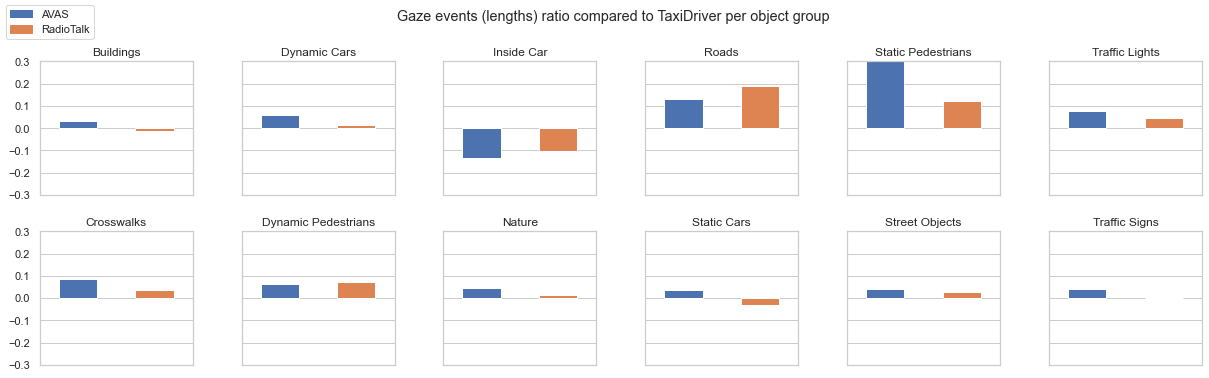

In [36]:
NROWS = 2
NCOLS = 6

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 5.5))
fig.suptitle(
    "Gaze events (lengths) ratio compared to TaxiDriver per object group\n"
)
fig.tight_layout()

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        grp = grp_cats[i]
        s = normalize_from_condition(
            hit_levs.groupby(["condition"])[grp].mean()
        )
        ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
        i += 1
        if c != 0:
            ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xlabel(None)
        ax.set_title(grp)
        ax.set_ylim(-0.3, 0.3)
        ax.set_xticks([])

avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="upper left")
plt.show()

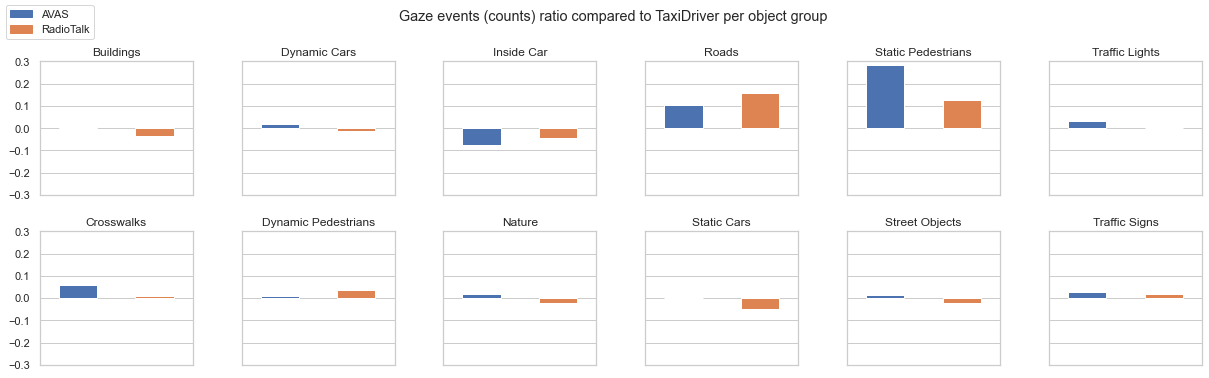

In [43]:
NROWS = 2
NCOLS = 6

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 5.5))
fig.suptitle(
    "Gaze events (counts) ratio compared to TaxiDriver per object group\n"
)
fig.tight_layout()

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        grp = grp_cats[i]
        s = normalize_from_condition(
            hit_cevs.groupby(["condition"])[grp].mean()
        )
        ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
        i += 1
        if c != 0:
            ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xlabel(None)
        ax.set_title(grp)
        ax.set_ylim(-0.3, 0.3)
        ax.set_xticks([])

avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="upper left")
plt.show()

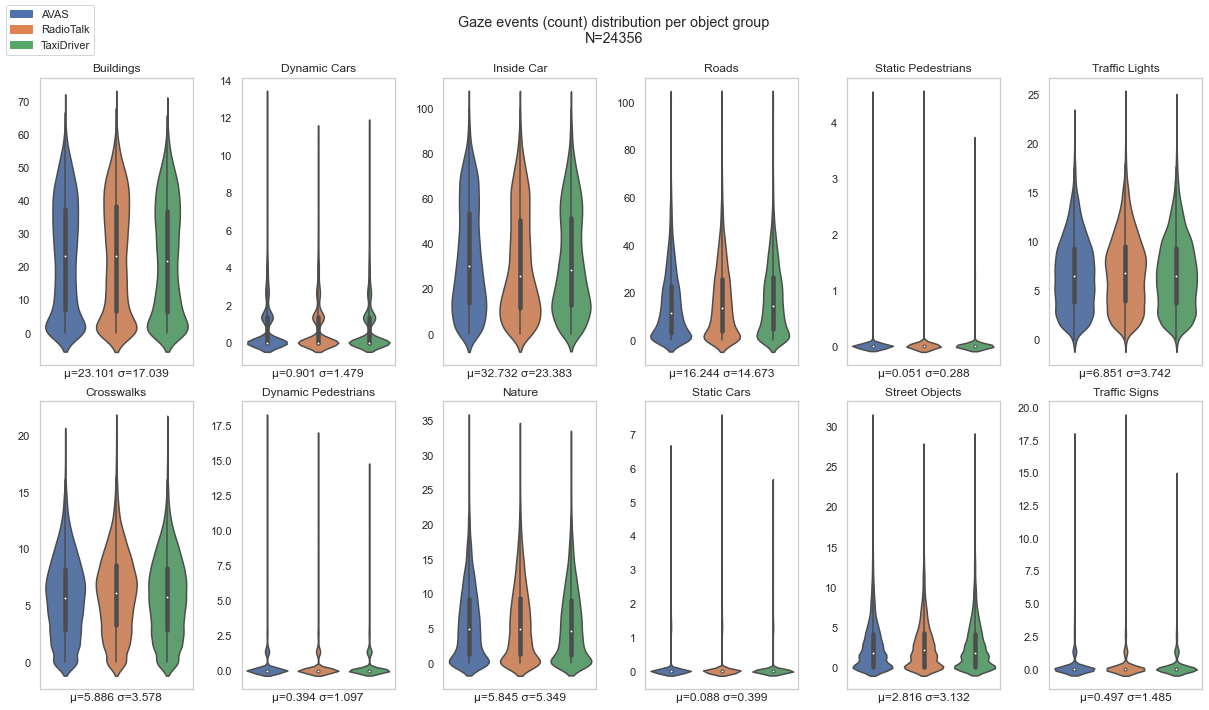

In [55]:
NROWS = 2
NCOLS = 6
N = hit_cevs.index.size

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 10))
fig.suptitle(f"Gaze events distribution (count %) per object group\nN={N}\n")
fig.tight_layout()

# h_cs = hit_cevs.groupby(["condition"])

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        grp = grp_cats[i]
        mean = hit_cevs[grp].mean()
        std = hit_cevs[grp].std()
        title_extra = f"μ={mean:.3f} σ={std:.3f}"
        # s = normalize_series(hit_cevs[grp])
        ax = sns.violinplot(data=hit_cevs, x="condition", y=grp, ax=axes[r, c])
        i += 1
        # if c != 0:
        #     ax.set_yticklabels([])
        ax.set_ylabel(None)
        ax.set_xticklabels([])
        ax.set_xlabel(None)
        ax.set_title(f"{grp}")
        ax.set_xlabel(title_extra)
        # ax.set_ylim(-10, 110)
        ax.set_xticks([])
        ax.grid(False)

avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
taxi_patch = mpatches.Patch(color=colors[2], label="TaxiDriver")
fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.show()

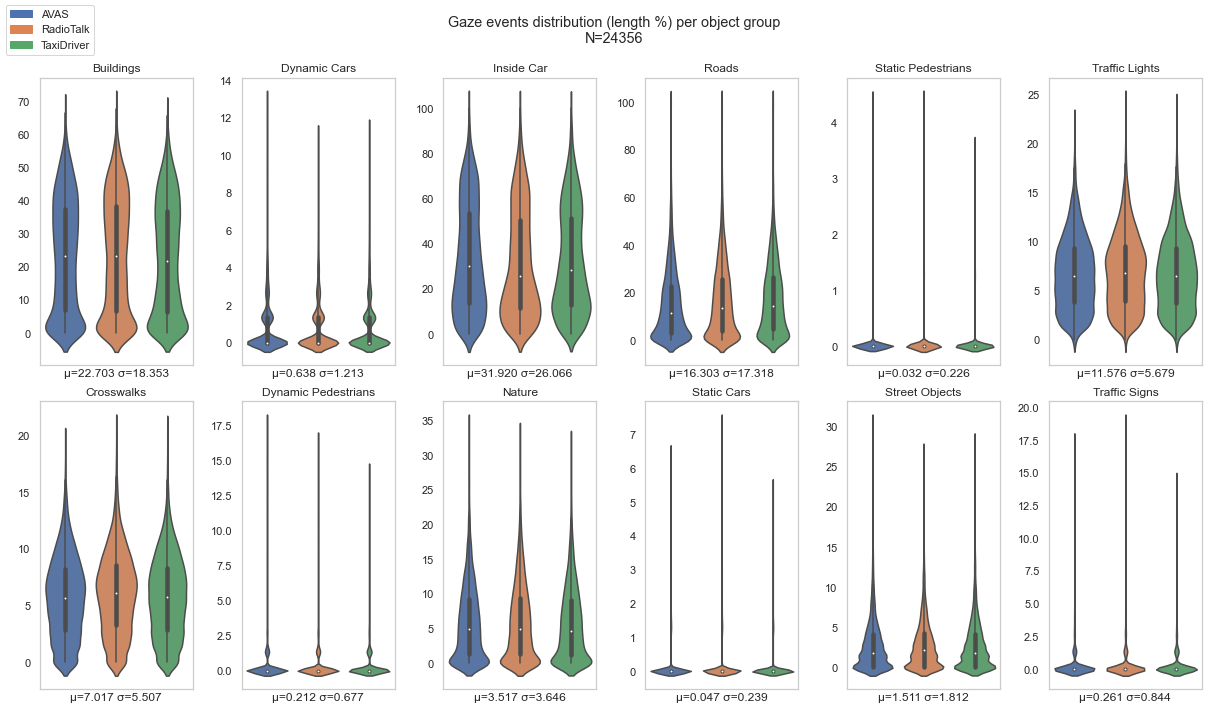

In [29]:
NROWS = 2
NCOLS = 6
N = hit_levs.index.size

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 10))
fig.suptitle(f"Gaze events distribution (length %) per object group\nN={N}\n")
fig.tight_layout()

# h_cs = hit_cevs.groupby(["condition"])

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        grp = grp_cats[i]
        mean = hit_levs[grp].mean()
        std = hit_levs[grp].std()
        title_extra = f"μ={mean:.3f} σ={std:.3f}"
        # s = normalize_series(hit_cevs[grp])
        ax = sns.violinplot(data=hit_cevs, x="condition", y=grp, ax=axes[r, c])
        i += 1
        # if c != 0:
        #     ax.set_yticklabels([])
        ax.set_ylabel(None)
        ax.set_xticklabels([])
        ax.set_xlabel(None)
        ax.set_title(f"{grp}")
        ax.set_xlabel(title_extra)
        # ax.set_ylim(-10, 110)
        ax.set_xticks([])
        ax.grid(False)

avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
taxi_patch = mpatches.Patch(color=colors[2], label="TaxiDriver")
fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.show()

In [22]:
parts = pd.read_csv("./participants_clean.csv")
parts = parts.set_index("id")

start = 65

for i in range(0, int(start), 5):
    cur = start - i if start - i >= 1 else 0

    sel = parts[parts["nulls_%"] <= cur]
    sample_size = sel.index.size

    sns.set(rc={"figure.figsize": (23, 7)})

    ax = (
        test.loc[sel.index]
        .groupby(["condition"])
        .mean()
        .transpose()
        .plot.bar(rot=0)
    )

    ax.set_ylabel("%")

    plt.title(f"Gaze events per object group (%nulls<={cur}, N={sample_size})")

    plt.show()

NameError: name 'test' is not defined

In [ ]:
ax = parts["nulls_%"].plot.hist(figsize=(10, 5), bins=100)
ax.set_xlim(0, 4)
parts["nulls_%"].plot.density(figsize=(10, 5), color=red)
# ax.set_xlim(0, 4)
plt.show()